# Pricing American Options by Finite Difference 
    - Replicating the Finite Difference implementation in {cite:p`longstaff2001valuing`
    
    - Replicating the values in Table 1.
    
    - Completely replicating the Table 1, as in the paper.

### TO DO:
- Add the theory/papers


In [1]:
# Import libraries
import numpy as np
from scipy.stats import norm
from scipy.linalg import lu_factor, lu_solve
import pandas as pd
import matplotlib.pyplot as plt

#from LSMC import lsmc_american_put, simulate_gbm_paths, laguerre_polynomials
#from Gaussian import gaussian_cf, sin_coeff

In [2]:
# exact price - Black-Scholes formula
def bs_put_price(S0, K, r, sigma, T):
    d1 = ( np.log(S0/K) + (r + 0.5*sigma**2) * T ) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    bs_put = -1 * norm.cdf(-d1)*S0 + norm.cdf(-d2)*K*np.exp(-r*T)
    return bs_put

- Simulate stock prices under Geometric Brownian Motion

- Define Laugerre polynomials

- Define LSMC-pricer (as in {cite:p}`longstaff2001valuing`)

In [3]:
# MC paths generator with antithetic sampling
def simulate_gbm_paths(S0, r, sigma, T, n_steps, n_paths):
    """ Antithetic: We input 50,000 paths and we get 100,000 paths """
    np.random.seed(1) 
    dt = T / n_steps

    # Generate randoms for half of n_paths
    Z = np.random.randn(n_paths, n_steps)
    
    # Create vector of paths and antithetic paths
    Z_all = np.vstack([Z, -Z])  
    
    # Initialize paths
    n_total = 2 * n_paths
    S = np.zeros((n_total, n_steps + 1))
    S[:, 0] = S0
    
    # Simulate paths
    for t in range(n_steps):
        S[:, t+1] = S[:, t] * np.exp((r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z_all[:, t])
    
    return S

def laguerre_polynomials(x, K):
    """ Calculate first three Laguerre polynomials
    x_scaled as x / K - to account for moneyness """
    # Scale x 
    x_scaled = x / K  # Normalize by strike price 
    
    # Calculate e^(-x/2) 
    exp_term = np.exp(-x_scaled/2)
    
    # Laguerre polynomials
    L0 = exp_term
    L1 = exp_term * (1 - x_scaled)
    L2 = exp_term * (1 - 2*x_scaled + x_scaled**2/2)
    
    return L0, L1, L2

def lsmc_american_put(S, K, r, T, n_steps):
    """ Least Squares Monte Carlo for American Put Option
    Similar approach as in Q1, but now we don't view it as tree/lattice 
    but a whole random path at different times t; ie more cts
    - going backwards in time, ie from terminal time (known payoff) to t=0.
    - we use regression to estimate the continuation value 
    - early exercise decision
    """
    n_paths = S.shape[0]
    dt = T / n_steps
    df = np.exp(-r * dt)
    
    # Initialize cash flow matrix
    cash_flows = np.zeros((n_paths, n_steps + 1))
    
    # Terminal payoff
    cash_flows[:, -1] = np.maximum(K - S[:, -1], 0)
    
    # Backward induction
    for t in range(n_steps - 1, 0, -1):
        # Current payoff if exercised
        payoff = np.maximum(K - S[:, t], 0)
        
        # Find in-the-money paths
        itm = payoff > 0 # will use as index for tracking
        
        if np.sum(itm) > 0:
            # Get stock prices for ITM paths
            X = S[itm, t]
            
            # Calculate basis functions according to paper
            L0, L1, L2 = laguerre_polynomials(X, K)
            
            # Data matrix: constant (intercept) + 3 Laguerre polynomials
            A = np.column_stack([np.ones_like(X), L0, L1, L2])
            
            # Calculate discounted future cash flows Y - response variable
                # Continuation value we are want to estimate
            Y = np.zeros(n_paths) #
            for s in range(t+1, n_steps+1):
                Y += cash_flows[:, s] * df**(s-t) 
            Y = Y[itm]
            
            # Regression to estimate continuation value
            beta = np.linalg.lstsq(A, Y)[0] # prediction
            #print(beta)
            cont_value = A @ beta
            #print(cont_value)
            
            # Exercise decision: exercise if immediate payoff >= continuation value
            exercise = payoff[itm] >= cont_value
            
            # Update cash flows
            itm_indices = np.where(itm)[0]
            for i, should_exercise in enumerate(exercise):
                idx = itm_indices[i]
                if should_exercise:
                    cash_flows[idx, t] = payoff[idx]
                    # Zero out future cash flows
                    cash_flows[idx, t+1:] = 0
    
    # for each path, find time when of exercise and discout it back to t=0
    option_values = np.zeros(n_paths)
    for i in range(n_paths):
        # Find all times when this option has positive cf
        exercise_times = np.where(cash_flows[i, :] > 0)[0]

        if len(exercise_times) > 0:
            t_exercise = exercise_times[0] # per path 1 exercise
            option_values[i] = cash_flows[i, t_exercise] * df**t_exercise # dicsouting it to t=0
    
    # Return mean value (since path dependent) and standard error
    mean_value = np.mean(option_values) # option PV 
    std_error = np.std(option_values) / np.sqrt(n_paths)
    
    return mean_value, std_error


## TO DO:
Add more theory! More equations, what exactly do we need to do? What are those operators that you are talking about? 

- Make sure that you know exactly and correctly what you are doing; avoid fancy stuff without the knowledge = empty.

### Finite difference for EU put option
Pricing an European put option:
- Path dependent case
    - Trace whole path each $\omega$-path
    - Feynman-Kac gives us the associated PDE to solve
    - To solve the PDE - approximate by Finite Difference
    - Moving forwards in time and central in space 
    - 
    
- Trace the whole lattice (imagine binomial tree) 

In [4]:
# forward finite difference 
L = 10 # keeping fixed as was provided by default
Nx = 1000
Nt = 1000
# Numerical instability issues when Nt=1000 or lower; in paper they use Nt=40_000
def fd_european_put(S0, K, r, sigma, T, Nx=1000, Nt=40000, L=10):
    h = L/Nx
    k = T/Nt
    T1  = np.diag([1]* (Nx-2), 1) - np.diag([1] * (Nx-2), -1)
    T2  = -2 * np.diag([1] * (Nx-1)) + np.diag([1]* (Nx-2), 1) + np.diag([1] * (Nx-2), -1)
    F = (1 - r*k) * np.diag([1] * (Nx-1))  + 0.5 *k * (sigma**2) /(h**2) * T2 +  k * (r-0.5*(sigma**2))/(2*h) * T1 # European

    # Creating (log)m-space
    mvec = np.linspace(start = np.log(S0)-L/2 + h, stop = np.log(S0) + L/2 - h, num=Nx-1)
    #mvec = np.linspace(start = -L/2 + h, stop = +L/2-h, num=Nx-1)
    U = np.zeros((Nx-1, Nt+1))
    U[:, 0] = np.maximum(K - np.exp(mvec), 0) # initial condition
    # EU-FD pricer -----------
    for i in range(Nt):
        time2mat = i*k
        # BC
        p = np.zeros(Nx-1)
        # Left BC - as S -> 0, PutVal -> Ke^{-r(T-t)}
        p[0] = ( 0.5 *k * (sigma**2) / (h**2) - k * (r-0.5*(sigma**2)) / (2*h) ) * K * np.exp(-r * time2mat)
        # Right BC -> PutVal -> 0, no contribution to p; S -> OOM
        U[:, i+1] = np.dot(F, U[:, i]) + p
        #U[:, i+1] = F @ U[:, i] + p 

    ftcs_price = np.interp(np.log(S0), mvec, U[:, Nt])
    return ftcs_price


### Finite difference for American put option
Pricing an America put option:
- Path dependent case
    - Trace whole path each $\omega$-path
    - Feynman-Kac gives us the associated PDE to solve
    - To solve the PDE - approximate by Finite Difference
    - Key difference is that we need to move backwards in time.
        - Since the payoff at the terminal time is known 
    - 
    
- Trace the whole lattice (imagine binomial tree) 

In [5]:
def fd_american_put(S0, K, r, sigma, T, Nx=1000, Nt=40000, L=10):
    """ Fast enough even for Nx=1000, Nt=40_000 
    Q: Why does it not match the FD_AM col precisely? 
    A: Discretisation error? Different interpolation? Paper is from 2001, methods improved.
    """
    # Grid parameters
    h = L/Nx  # spatial step
    k = T/Nt  # time step

    # First derivative matrix (centered differences)
    # T1 = np.zeros((Nx-1, Nx-1))
    # for i in range(1, Nx-2):
    #     T1[i, i-1] = -1
    #     T1[i, i+1] = 1
    # T1 = T1 / (2*h)
    #print(T1)
    # # Second derivative matrix
    # T2 = np.zeros((Nx-1, Nx-1))
    # for i in range(1, Nx-2):
    #     T2[i, i-1] = 1
    #     T2[i, i] = -2
    #     T2[i, i+1] = 1
    # T2 = T2 / (h**2)
    #print(T2)

    T1  = np.diag([1]* (Nx-2), 1) - np.diag([1] * (Nx-2), -1)
    #print(T1)
    T2  = -2 * np.diag([1] * (Nx-1)) + np.diag([1]* (Nx-2), 1) + np.diag([1] * (Nx-2), -1) # 2nd order derivative
    #print(T2)

    # Grid in log-space 
    mvec = np.linspace(start = np.log(S0)- L/2 + h, stop = np.log(S0)+ L/2 - h, num=Nx-1) # shift grid by logS0 
    stock_prices = np.exp(mvec)

    # Matrix for implicit scheme is (I - k*A)
    I = np.eye(Nx-1)
    A = (0.5 * sigma**2 / h**2) * T2 + ((r - 0.5*sigma**2) / (2*h)) * T1 - r * np.eye(Nx-1)
    # M = I - k*A
    #M = (1 + r*k)*I - k*0.5*sigma**2*T2 - k*r*T1 + k*0.5*sigma**2*T1 
    #   F = (1 - r*k) * np.diag([1] * (Nx-1))  + 0.5 *k * (sigma**2) /(h**2) * T2 +  k * (r-0.5*(sigma**2))/(2*h) * T1
    M = (1 + r*k)*I - k*0.5*(sigma**2)/(h**2)*T2 - k*r*T1/(2*h) + k*0.5*(sigma**2)/(2*h)*T1 
    #M = np.eye(Nx-1) - k*A # both methods give the same cols results
    lu, piv = lu_factor(M) # avoid computing inverse; lu-factorise M-matrix

    ## Initialise
    # American put value at maturity
    V = np.maximum(K - stock_prices, 0) # known payoff
    intrinsic_value= V.copy()
    # Store values
    american_values = np.zeros((Nx-1, Nt+1))
    american_values[:, -1] = V
    # Boundary conditions S*N(-d2) - Ke^{-rT}*N(-d1)
    # At S = 0 (m -> -\infty), put value is K
    # At S -> \infty (m-> \infty), put value is 0

    # AM-pricer - backward induction with early exercise rule ---------
    b = np.empty_like(V)
    for n in range(Nt-1, -1, -1):
        # Current time (working backward); recall k = T/Nt
        t = n * k # start from terminal time
        # rhs
        b[:] = V
        b = V.copy()
        # Apply boundary conditions
        # Lower boundary: as S->0, American put value -> K; without e^{-rt}
        #b[0] += k * (0.5*sigma**2/h**2 - (r-0.5*sigma**2)/(2*h)) * K
        b[0] = ( 0.5 *k * (sigma**2) / (h**2) - k * (r-0.5*(sigma**2)) / (2*h) ) * K
        # Upper boundary: as S-> \infty, put value -> 0
            # == 0
        # Continuation value (if not exercised)
        # Solve the linear system: M * V_new = b
        #V_new = np.linalg.solve(M, b) # we are computing an inverse, not good. Can we do better?
        V_new = lu_solve((lu, piv), b)

        # RULE FOR EARLY EXERICISE ---------
        # Apply early exercise constraint: V >= max(K - S, 0)
        intrinsic_value = np.maximum(K - stock_prices, 0) 
        V = np.maximum(V_new, intrinsic_value)
        
        # Store values
        american_values[:, n] = V

    # Interpolate to get price at S0
    american_price = np.interp(np.log(S0), mvec, V)
    return american_price


### Define table replicating functions

In [6]:
def replicate_table1_european():
    """ Replicate European put values from Table 1 using FD method
    Compare with Black-Scholes closed form
    - noting early ex. values are also negative as this comparison is for 2 EU-put options
    """
    # Fixed parameters from the paper
    K = 40
    r = 0.06
    
    # Parameters from Table 1
    params = [
        (36, 0.20, 1), (36, 0.20, 2), (36, 0.40, 1), (36, 0.40, 2),
        (38, 0.20, 1), (38, 0.20, 2), (38, 0.40, 1), (38, 0.40, 2),
        (40, 0.20, 1), (40, 0.20, 2), (40, 0.40, 1), (40, 0.40, 2),
        (42, 0.20, 1), (42, 0.20, 2), (42, 0.40, 1), (42, 0.40, 2),
        (44, 0.20, 1), (44, 0.20, 2), (44, 0.40, 1), (44, 0.40, 2)
    ]
    
    print("\nFinite Difference European Put Pricing")
    print("")
    print(f"{'S':>4} {'vol':>4} {'T':>3} | {'FD European':>12} | {'BS European':>12} | {'Difference':>10}")
    print("-"*70)

    results = []
    for S0, sigma, T in params:
        # Calculate FD price
        fd_price = fd_european_put(S0, K, r, sigma, T)
        # Calculate Black-Scholes price
        bs_price = bs_put_price(S0, K, r, sigma, T)
        # Calculate difference
        diff = fd_price - bs_price
        
        # Display results
        print(f"{S0:>4} {sigma:>5.2f} {T:>3}   "
              f"{fd_price:>12.4f}   "
              f"{bs_price:>12.4f}   "
              f"{diff:>10.6f}")
        
        results.append({
            'S': S0,
            'sigma': sigma,
            'T': T,
            'FD_European': fd_price,
            'BS_European': bs_price,
            'Early ex. value': diff
        })
    
    df_results = pd.DataFrame(results)
    
    return df_results

df_results1 = replicate_table1_european()


Finite Difference European Put Pricing

   S  vol   T |  FD European |  BS European | Difference
----------------------------------------------------------------------


  36  0.20   1         3.8445         3.8443     0.000170


  36  0.20   2         3.7631         3.7630     0.000087


  36  0.40   1         6.7114         6.7114     0.000045


  36  0.40   2         7.7001         7.7000     0.000044


  38  0.20   1         2.8515         2.8519    -0.000441


  38  0.20   2         2.9903         2.9906    -0.000300


  38  0.40   1         5.8341         5.8343    -0.000217


  38  0.40   2         6.9787         6.9788    -0.000128


  40  0.20   1         2.0655         2.0664    -0.000911


  40  0.20   2         2.3553         2.3559    -0.000594


  40  0.40   1         5.0592         5.0596    -0.000439


  40  0.40   2         6.3257         6.3260    -0.000273


  42  0.20   1         1.4640         1.4645    -0.000500


  42  0.20   2         1.8410         1.8414    -0.000334


  42  0.40   1         4.3785         4.3787    -0.000241


  42  0.40   2         5.7355         5.7356    -0.000142


  44  0.20   1         1.0169         1.0169    -0.000006


  44  0.20   2         1.4292         1.4292    -0.000020


  44  0.40   1         3.7828         3.7828     0.000027


  44  0.40   2         5.2020         5.2020     0.000036


In [7]:
def replicate_table1_american(): # aside table
    """ Replicate American put values from Table 1 using FD method
        Compare with Black-Scholes closed form
    """
    # Fixed parameters from the paper
    K = 40
    r = 0.06
    
    # Parameters from Table 1
    params = [
        (36, 0.20, 1), (36, 0.20, 2), (36, 0.40, 1), (36, 0.40, 2),
        (38, 0.20, 1), (38, 0.20, 2), (38, 0.40, 1), (38, 0.40, 2),
        (40, 0.20, 1), (40, 0.20, 2), (40, 0.40, 1), (40, 0.40, 2),
        (42, 0.20, 1), (42, 0.20, 2), (42, 0.40, 1), (42, 0.40, 2),
        (44, 0.20, 1), (44, 0.20, 2), (44, 0.40, 1), (44, 0.40, 2)
    ]
    
    print("\nFinite Difference American Put Pricing vs. Closed form European (BS)")
    results = []
    for S0, sigma, T in params:
        # Calculate FD price
        fd_price = fd_american_put(S0, K, r, sigma, T)
        # Calculate Black-Scholes price
        bs_price = bs_put_price(S0, K, r, sigma, T)
        # Calculate difference
        diff = fd_price - bs_price
        
        # Display results
        print(f"{S0:>4} {sigma:>5.2f} {T:>3}   "
              f"{fd_price:>12.4f}   "
              f"{bs_price:>12.4f}   "
              f"{diff:>10.6f}")
        
        results.append({
            'S': S0,
            'sigma': sigma,
            'T': T,
            'FD_American': fd_price,
            'BS_European': bs_price,
            'Early exercise': diff
        })
    
    # Create DataFrame for further analysis
    df_results = pd.DataFrame(results)
    
    return df_results

df_results2 = replicate_table1_american()


Finite Difference American Put Pricing vs. Closed form European (BS)


  36  0.20   1         4.4860         3.8443     0.641698


  36  0.20   2         4.8477         3.7630     1.084740


  36  0.40   1         7.1087         6.7114     0.397328


  36  0.40   2         8.5140         7.7000     0.813911


  38  0.20   1         3.2563         2.8519     0.404407


  38  0.20   2         3.7507         2.9906     0.760191


  38  0.40   1         6.1542         5.8343     0.319844


  38  0.40   2         7.6746         6.9788     0.695772


  40  0.20   1         2.3185         2.0664     0.252081


  40  0.20   2         2.8892         2.3559     0.533339


  40  0.40   1         5.3177         5.0596     0.258088


  40  0.40   2         6.9230         6.3260     0.597037


  42  0.20   1         1.6204         1.4645     0.155880


  42  0.20   2         2.2161         1.8414     0.374785


  42  0.40   1         4.5877         4.3787     0.209016


  42  0.40   2         6.2499         5.7356     0.514286


  44  0.20   1         1.1126         1.0169     0.095697


  44  0.20   2         1.6930         1.4292     0.263755


  44  0.40   1         3.9526         3.7828     0.169779


  44  0.40   2         5.6465         5.2020     0.444528


In [8]:
def replicate_table1():
    """ Replication of Table 1 format from the paper   """
    # Fixed parameters
    K = 40
    r = 0.06
    
    # Parameters
    params = [
        (36, 0.20, 1), (36, 0.20, 2), (36, 0.40, 1), (36, 0.40, 2),
        (38, 0.20, 1), (38, 0.20, 2), (38, 0.40, 1), (38, 0.40, 2),
        (40, 0.20, 1), (40, 0.20, 2), (40, 0.40, 1), (40, 0.40, 2),
        (42, 0.20, 1), (42, 0.20, 2), (42, 0.40, 1), (42, 0.40, 2),
        (44, 0.20, 1), (44, 0.20, 2), (44, 0.40, 1), (44, 0.40, 2)
    ]
    
    print("\nTable 1: American put values, closed form European and early exercise value")
    print("")
    print("                     American       BS European    Early Ex.")
    print("Price    vol    T    Put            Put            value")
    print("-" * 60)
    
    results = []
    for S0, sigma, T in params:
        european = bs_put_price(S0, K, r, sigma, T)
        american = fd_american_put(S0, K, r, sigma, T)
        ex_value = american - european
        
        print(f"{S0:3.0f}     {sigma:4.2f}    {T:1.0f}   "
              f"{american:7.4f}        {european:7.4f}         {ex_value:6.4f}")
    
    results.append({
            'S': S0,
            'vol': sigma,
            'T': T,
            'FD_American': american,
            'BS_European': european,
            'Early exercise': ex_value
        })
    df_results = pd.DataFrame(results)
    
    return df_results

df_results3 = replicate_table1()


Table 1: American put values, closed form European and early exercise value

                     American       BS European    Early Ex.
Price    vol    T    Put            Put            value
------------------------------------------------------------


 36     0.20    1    4.4860         3.8443         0.6417


 36     0.20    2    4.8477         3.7630         1.0847


 36     0.40    1    7.1087         6.7114         0.3973


 36     0.40    2    8.5140         7.7000         0.8139


 38     0.20    1    3.2563         2.8519         0.4044


 38     0.20    2    3.7507         2.9906         0.7602


 38     0.40    1    6.1542         5.8343         0.3198


 38     0.40    2    7.6746         6.9788         0.6958


 40     0.20    1    2.3185         2.0664         0.2521


 40     0.20    2    2.8892         2.3559         0.5333


 40     0.40    1    5.3177         5.0596         0.2581


 40     0.40    2    6.9230         6.3260         0.5970


 42     0.20    1    1.6204         1.4645         0.1559


 42     0.20    2    2.2161         1.8414         0.3748


 42     0.40    1    4.5877         4.3787         0.2090


 42     0.40    2    6.2499         5.7356         0.5143


 44     0.20    1    1.1126         1.0169         0.0957


 44     0.20    2    1.6930         1.4292         0.2638


 44     0.40    1    3.9526         3.7828         0.1698


 44     0.40    2    5.6465         5.2020         0.4445


#### Convergence analysis

In [9]:
def convergence_plot():
    """ We want to use the MC with overkilled params to provide as accurate as possible price 
        and compare the fd_americal_put() implementation as grid sizes increases,
        against the price provided by the LSMC-pricer.
    """
    # Parameters
    S0, K, r, sigma, T = 36, 40, 0.06, 0.20, 1
    # S0, K, r, sigma, T = 44, 40, 0.06, 0.20, 1
    # S0, K, r, sigma, T = 36, 40, 0.06, 0.40, 1
    # S0, K, r, sigma, T = 40, 40, 0.06, 0.40, 1
    # Get LSMC benchmark with very high accuracy
    print("Computing LSMC benchmark value with 1 million paths")
    np.random.seed(1)
    S_paths = simulate_gbm_paths(S0, r, sigma, T, 50, 500000)  # 1mil paths total
    lsmc_value, lsmc_se = lsmc_american_put(S_paths, K, r, T, 50)
    print(f"LSMC benchmark: {lsmc_value:.6f} (s.e. = {lsmc_se:.6f})")
    
    # Test FD conv
    print("\nFD convergence")
    grid_sizes = [(100, 1000), (250, 5000), (500, 10000), (750, 20000), (1000, 40000)] # last is paper 
    nx_vals = [g[0] for g in grid_sizes]
    fd_vals = [fd_american_put(S0, K, r, sigma, T, Nx=Nx, Nt=Nt) for Nx, Nt in grid_sizes]
    
    # Test LSMC standard error conv
    print("\nLSMC standard error convergence")
    n_paths_list = [5000, 10000, 25000, 50000, 75000, 100000]
    lsmc_ses = []
    
    for n_paths in n_paths_list:
        np.random.seed(1)
        S_paths = simulate_gbm_paths(S0, r, sigma, T, 50, n_paths//2)
        _, se = lsmc_american_put(S_paths, K, r, T, 50)
        lsmc_ses.append(se)
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Left: FD price convergence
    ax1.plot(nx_vals, fd_vals, 'bo-', markersize=10, linewidth=2.5, label=f'FD Prices = {fd_vals[-1]:.6f}')
    ax1.axhline(y=lsmc_value, color='red', linestyle='--', linewidth=2, 
                label=f'LSMC = {lsmc_value:.4f}')
    
    ax1.set_xlabel('Spatial Grid Points (Nx)', fontsize=12)
    ax1.set_ylabel('American Put Price', fontsize=12)
    ax1.set_title('FD Price Convergence', fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10)
    
    # Right: LSMC standard error reduction
    ax2.loglog(n_paths_list, lsmc_ses, 'ro-', markersize=10, linewidth=2.5, label='LSMC Std Error')
    
    ax2.set_xlabel('Number of MC paths', fontsize=12)
    ax2.set_ylabel('Standard Error (log scale)', fontsize=12)
    ax2.set_title('LSMC Error', fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=10)
    
    plt.suptitle('FD Convergence to LSMC & Monte Carlo Standard Error', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    print(f"\nFinal Results:")
    print(f"FD (1000x40000): {fd_vals[-1]:.6f}")
    print(f"LSMC benchmark: {lsmc_value:.6f}")
    print(f"Difference: {abs(fd_vals[-1] - lsmc_value):.6f}")


Computing LSMC benchmark value with 1 million paths


LSMC benchmark: 4.478278 (s.e. = 0.002902)

FD convergence



LSMC standard error convergence


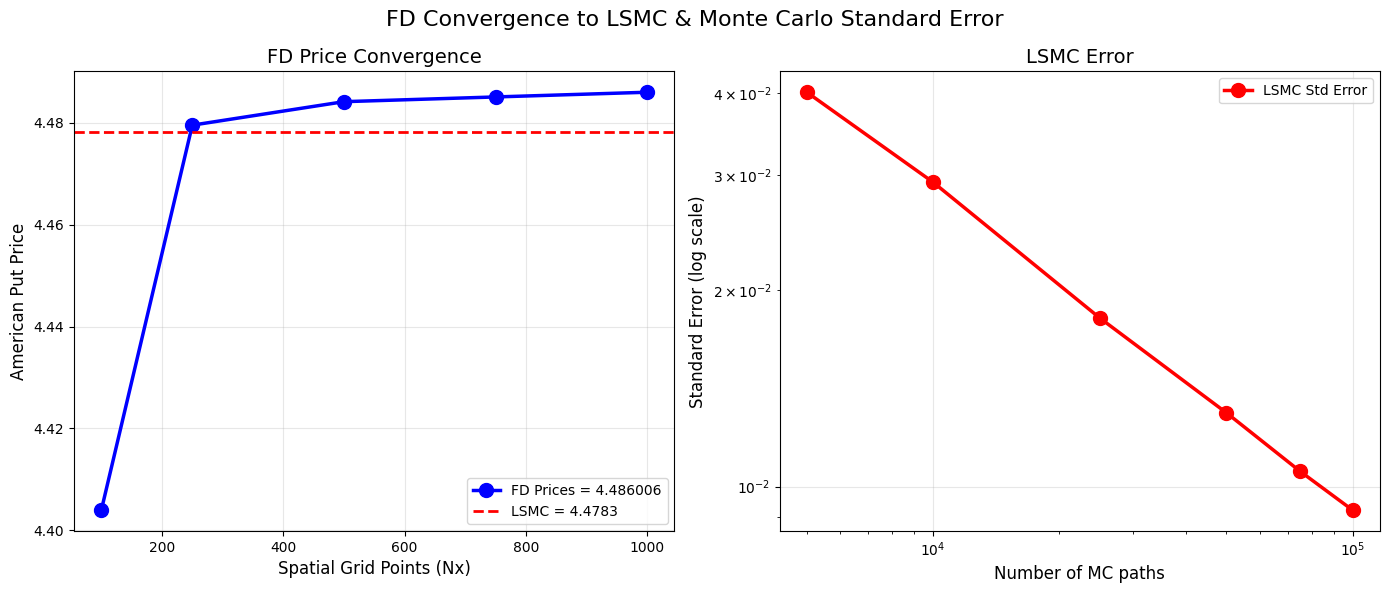


Final Results:
FD (1000x40000): 4.486006
LSMC benchmark: 4.478278
Difference: 0.007728

Generating Complete Table 1


KeyboardInterrupt: 

In [10]:
def generate_table1(): # Generates the complete Table 1
    """ Generate complete Table 1 """
    # Fixed parameters
    K = 40
    r = 0.06
    
    # Table parameters
    params = [
        (36, 0.20, 1), (36, 0.20, 2), (36, 0.40, 1), (36, 0.40, 2),
        (38, 0.20, 1), (38, 0.20, 2), (38, 0.40, 1), (38, 0.40, 2),
        (40, 0.20, 1), (40, 0.20, 2), (40, 0.40, 1), (40, 0.40, 2),
        (42, 0.20, 1), (42, 0.20, 2), (42, 0.40, 1), (42, 0.40, 2),
        (44, 0.20, 1), (44, 0.20, 2), (44, 0.40, 1), (44, 0.40, 2)
    ]
    
    results = []
    
    for S0, sigma, T in params:
        # Closed form EU
        european = bs_put_price(S0, K, r, sigma, T)
        
        # FD AM put pricer
        american_fd = fd_american_put(S0, K, r, sigma, T)
        early_ex_fd = american_fd - european
        
        # LSMC-pricer
        np.random.seed(1)
        n_steps = int(T * 50)
        S_paths = simulate_gbm_paths(S0, r, sigma, T, n_steps, 50000) # as in paper
        american_lsmc, se_lsmc = lsmc_american_put(S_paths, K, r, T, n_steps)
        early_ex_lsmc = american_lsmc - european
        
        # Difference in early exercise 
        diff = early_ex_lsmc - early_ex_fd
        
        results.append({
            'S': S0, 'sigma': sigma, 'T': T,
            'FD_American': american_fd, 'European': european, 'FD_Early_Ex': early_ex_fd,
            'LSMC_American': american_lsmc, 'SE': se_lsmc, 'LSMC_Early_Ex': early_ex_lsmc,
            'Difference': diff
        })
    
    df = pd.DataFrame(results)
    
    return print(df)

if __name__ == "__main__":
    convergence_plot()
    print("\nGenerating Complete Table 1")
    generate_table1() # uncomment to generate complete Table 1 - same as the last Table in the report